# **Qwen-Image-Edit-2509 with Mask Editor**
- This notebook preserves the input image’s aspect ratio much better than previous versions even without using the mask editor. I plan to write a detailed guide on how to use it and will include the link here when it’s ready.
- The Qwen Image Edit 2509 model works best with clear prompts e.g for 3 uploaded images: "Let the girl in image 1 wear the outfit from image 2 and assume the pose from image 3." While inpainting with the mask editor offers more control, it produces less impressive results and sometimes does nothing. You can try the mask editor, but prompt-only editing generally gives better results, as that’s how the model was originally designed to work.
- You can find models here: https://huggingface.co/QuantStack/Qwen-Image-Edit-2509-GGUF/tree/main
- Enabling the speedup LoRA will internally set the steps to 4 and the CFG to 1.
- To use a lora, put its huggingface or civitai download link in the `lora_download_url` textbox, select the `download_lora` checkbox, and if using civitai, input your civitai token before running the code to `Prepare Environment`. Remember to describe the main subject of the image and include the trigger words for the LoRA in the prompt.
- Github project page: https://github.com/QwenLM/Qwen-Image
- Notebook source: https://github.com/Isi-dev/Google-Colab_Notebooks
- Premium notebooks I highly recommend: https://isinse.gumroad.com/
- Even $1 helps support my work: https://buymeacoffee.com/isiomo



In [1]:

# qwen_model_download_url: https://huggingface.co/city96/Qwen-Image-gguf/resolve/main/qwen-image-Q4_K_M.gguf

# qwen_edit_model_download_url: https://huggingface.co/QuantStack/Qwen-Image-Edit-GGUF/resolve/main/Qwen_Image_Edit-Q4_K_M.gguf

# qwen_edit_model_2509_download_url: https://huggingface.co/QuantStack/Qwen-Image-Edit-2509-GGUF/resolve/main/Qwen-Image-Edit-2509-Q4_K_M.gguf


















# @markdown # 💥1. Prepare Environment
# !pip install --quiet torch torchvision --index-url https://download.pytorch.org/whl/cu124
# !pip install --upgrade --quiet torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install torch==2.8.0 torchvision==0.23.0
%cd /content

from IPython.display import clear_output
!git clone --branch ComfyUI_v0.3.60 https://github.com/Isi-dev/ComfyUI
clear_output()
%cd /content/ComfyUI/custom_nodes
!git clone https://github.com/Isi-dev/ComfyUI_Img2PaintingAssistant
!git clone --branch forQwen https://github.com/Isi-dev/ComfyUI_GGUF.git
clear_output()
!git clone https://github.com/Isi-dev/comfyui_controlnet_aux
clear_output()
# !git clone https://github.com/Isi-dev/ComfyUI_KJNodes.git
# clear_output()
%cd /content/ComfyUI/custom_nodes/ComfyUI_GGUF
!pip install -r requirements.txt
clear_output()
%cd /content/ComfyUI/custom_nodes/comfyui_controlnet_aux
!pip install -r requirements.txt
clear_output()

# %cd /content/ComfyUI/custom_nodes/ComfyUI_KJNodes
# !pip install -r requirements.txt
# clear_output()
%cd /content/ComfyUI

import subprocess
import sys


def install_pip_packages():
    packages = [
        'torchsde',
        'av',
        'diffusers',
        # 'transformers',
        'xformers==0.0.32.post1',
        'accelerate',
        'triton==3.4',
        'sageattention',
        # 'omegaconf',
        # 'tqdm',
        # 'librosa',
        'einops',
        'spandrel',
        'albumentations',
        'insightface',
        'onnx',
        'opencv-python',
        'segment_anything',
        'ultralytics',
        'onnxruntime',
        'onnxruntime-gpu'

    ]



    for package in packages:
        try:
            # Run pip install silently (using -q)
            subprocess.run(
                [sys.executable, '-m', 'pip', 'install', '-q', package],
                check=True,
                capture_output=True
            )
            print(f"✓ {package} installed")
        except subprocess.CalledProcessError as e:
            print(f"✗ Error installing {package}: {e.stderr.decode().strip() or 'Unknown error'}")

def install_apt_packages():
    packages = ['aria2']

    try:
        # Run apt install silently (using -qq)
        subprocess.run(
            ['apt-get', '-y', 'install', '-qq'] + packages,
            check=True,
            capture_output=True
        )
        print("✓ apt packages installed")
    except subprocess.CalledProcessError as e:
        print(f"✗ Error installing apt packages: {e.stderr.decode().strip() or 'Unknown error'}")


print("Installing pip packages...")
install_pip_packages()
!pip install albumentations onnx opencv-python onnxruntime
!pip install onnxruntime-gpu
clear_output()  # Clear the pip installation output

print("Installing apt packages...")
install_apt_packages()
clear_output()  # Clear the apt installation output

print("Installation completed with status:")
print("- All pip packages installed successfully" if '✗' not in install_pip_packages.__code__.co_consts else "- Some pip packages had issues")
print("- apt packages installed successfully" if '✗' not in install_apt_packages.__code__.co_consts else "- apt packages had issues")

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import torch
import numpy as np
from PIL import Image
import gc
import torch
from PIL import Image
import random
import imageio
from google.colab import files
from IPython.display import display, HTML, Image as IPImage
sys.path.insert(0, '/content/ComfyUI')

from nodes import (
    DualCLIPLoader,
    CLIPLoader,
    CLIPTextEncode,
    VAEEncode,
    VAEEncodeForInpaint,
    VAEDecode,
    VAELoader,
    KSampler,
    KSamplerAdvanced,
    ConditioningZeroOut,
    InpaintModelConditioning,
    ImageScaleBy,
    ImageScale,
    LoraLoaderModelOnly,
    LoadImage,
    SaveImage
)

from custom_nodes.ComfyUI_GGUF.nodes import UnetLoaderGGUF

from comfy_extras.nodes_qwen import TextEncodeQwenImageEditPlus

from comfy_extras.nodes_edit_model import ReferenceLatent

from comfy_extras.nodes_hunyuan import EmptyHunyuanLatentVideo

from comfy_extras.nodes_model_advanced import ModelSamplingSD3

from comfy_extras.nodes_cfg import CFGNorm



# from comfy_extras.nodes_flux import (
#     FluxGuidance,
#     FluxKontextImageScale
# )

# from comfy_extras.nodes_images import (
#     ImageCrop,
#     ImageStitch

# )

from custom_nodes.ComfyUI_Img2PaintingAssistant.image_to_painting_node import Painting

from comfy_extras.nodes_sd3 import EmptySD3LatentImage

from comfy_extras.nodes_post_processing import ImageScaleToTotalPixels

from comfy_extras.nodes_mask import SolidMask

from custom_nodes.comfyui_controlnet_aux.node_wrappers.dwpose import DWPose_Preprocessor

def image_width_height(image):
    if image.ndim == 4:
        _, height, width, _ = image.shape
    elif image.ndim == 3:
        height, width, _ = image.shape
    else:
        raise ValueError(f"Unsupported image shape: {image.shape}")
    return width, height

def compute_value_from_size(width: int, height: int) -> float:
    return float(width * height / 4)

def fillMask(width, height, mask, box=(0, 0), color=0):
    bg = Image.new("L", (width, height), color)
    bg.paste(mask, box, mask)
    return bg

def emptyImage(width, height, batch_size=1, color=0):
    r = torch.full([batch_size, height, width, 1], ((color >> 16) & 0xFF) / 0xFF)
    g = torch.full([batch_size, height, width, 1], ((color >> 8) & 0xFF) / 0xFF)
    b = torch.full([batch_size, height, width, 1], ((color) & 0xFF) / 0xFF)
    return torch.cat((r, g, b), dim=-1)

def pil2tensor(image):
  return torch.from_numpy(np.array(image).astype(np.float32) / 255.0).unsqueeze(0)

def tensor2pil(image):
    return Image.fromarray(np.clip(255. * image.cpu().numpy().squeeze(), 0, 255).astype(np.uint8))

def lanczos(samples, width, height):
    images = [Image.fromarray(np.clip(255. * image.movedim(0, -1).cpu().numpy(), 0, 255).astype(np.uint8)) for image in samples]
    images = [image.resize((width, height), resample=Image.Resampling.LANCZOS) for image in images]
    images = [torch.from_numpy(np.array(image).astype(np.float32) / 255.0).movedim(-1, 0) for image in images]
    result = torch.stack(images)
    return result.to(samples.device, samples.dtype)

def bislerp(samples, width, height):
    def slerp(b1, b2, r):
        '''slerps batches b1, b2 according to ratio r, batches should be flat e.g. NxC'''

        c = b1.shape[-1]

        #norms
        b1_norms = torch.norm(b1, dim=-1, keepdim=True)
        b2_norms = torch.norm(b2, dim=-1, keepdim=True)

        #normalize
        b1_normalized = b1 / b1_norms
        b2_normalized = b2 / b2_norms

        #zero when norms are zero
        b1_normalized[b1_norms.expand(-1,c) == 0.0] = 0.0
        b2_normalized[b2_norms.expand(-1,c) == 0.0] = 0.0

        #slerp
        dot = (b1_normalized*b2_normalized).sum(1)
        omega = torch.acos(dot)
        so = torch.sin(omega)

        #technically not mathematically correct, but more pleasing?
        res = (torch.sin((1.0-r.squeeze(1))*omega)/so).unsqueeze(1)*b1_normalized + (torch.sin(r.squeeze(1)*omega)/so).unsqueeze(1) * b2_normalized
        res *= (b1_norms * (1.0-r) + b2_norms * r).expand(-1,c)

        #edge cases for same or polar opposites
        res[dot > 1 - 1e-5] = b1[dot > 1 - 1e-5]
        res[dot < 1e-5 - 1] = (b1 * (1.0-r) + b2 * r)[dot < 1e-5 - 1]
        return res

def common_upscale(samples, width, height, upscale_method, crop):
        orig_shape = tuple(samples.shape)
        if len(orig_shape) > 4:
            samples = samples.reshape(samples.shape[0], samples.shape[1], -1, samples.shape[-2], samples.shape[-1])
            samples = samples.movedim(2, 1)
            samples = samples.reshape(-1, orig_shape[1], orig_shape[-2], orig_shape[-1])
        if crop == "center":
            old_width = samples.shape[-1]
            old_height = samples.shape[-2]
            old_aspect = old_width / old_height
            new_aspect = width / height
            x = 0
            y = 0
            if old_aspect > new_aspect:
                x = round((old_width - old_width * (new_aspect / old_aspect)) / 2)
            elif old_aspect < new_aspect:
                y = round((old_height - old_height * (old_aspect / new_aspect)) / 2)
            s = samples.narrow(-2, y, old_height - y * 2).narrow(-1, x, old_width - x * 2)
        else:
            s = samples

        if upscale_method == "bislerp":
            out = bislerp(s, width, height)
        elif upscale_method == "lanczos":
            out = lanczos(s, width, height)
        else:
            out = torch.nn.functional.interpolate(s, size=(height, width), mode=upscale_method)

        if len(orig_shape) == 4:
            return out

        out = out.reshape((orig_shape[0], -1, orig_shape[1]) + (height, width))
        return out.movedim(2, 1).reshape(orig_shape[:-2] + (height, width))

def make(image_1, direction="left-right", pixels=0, image_2=None, mask_1=None, mask_2=None):
    if image_2 is None:
      image_2 = emptyImage(image_1.shape[2], image_1.shape[1])
      mask_2 = torch.full((1, image_1.shape[1], image_1.shape[2]), 1, dtype=torch.float32, device="cpu")

    elif image_2 is not None and mask_2 is None:
      raise ValueError("mask_2 is required when image_2 is provided")
    if pixels > 0:
      _, img2_h, img2_w, _ = image_2.shape
      h = pixels if direction == 'left-right' else int(img2_h * (pixels / img2_w))
      w = pixels if direction == 'top-bottom' else int(img2_w * (pixels / img2_h))

      image_2 = image_2.movedim(-1, 1)
      image_2 = common_upscale(image_2, w, h, 'bicubic', 'disabled')
      image_2 = image_2.movedim(1, -1)

      orig_image_2 = tensor2pil(image_2)
      orig_mask_2 = tensor2pil(mask_2).convert('L')
      orig_mask_2 = orig_mask_2.resize(orig_image_2.size)
      mask_2 = pil2tensor(orig_mask_2)

    _, img1_h, img1_w, _ = image_1.shape
    _, img2_h, img2_w, _ = image_2.shape

    image, mask, context_mask = None, None, None

    # resize
    if img1_h != img2_h and img1_w != img2_w:
      width, height = img2_w, img2_h
      if direction == 'left-right' and img1_h != img2_h:
        scale_factor = img2_h / img1_h
        width = round(img1_w * scale_factor)
      elif direction == 'top-bottom' and img1_w != img2_w:
        scale_factor = img2_w / img1_w
        height = round(img1_h * scale_factor)

      image_1 = image_1.movedim(-1, 1)
      image_1 = common_upscale(image_1, width, height, 'bicubic', 'disabled')
      image_1 = image_1.movedim(1, -1)

    if mask_1 is None:
      mask_1 = torch.full((1, image_1.shape[1], image_1.shape[2]), 0, dtype=torch.float32, device="cpu")

    orig_image_1 = tensor2pil(image_1)
    orig_mask_1 = tensor2pil(mask_1).convert('L')

    if orig_mask_1.size != orig_image_1.size:
      orig_mask_1 = orig_mask_1.resize(orig_image_1.size)

    img1_w, img1_h = orig_image_1.size
    image_1 = pil2tensor(orig_image_1)
    image = torch.cat((image_1, image_2), dim=2) if direction == 'left-right' else torch.cat((image_1, image_2),
                                                                                             dim=1)

    context_mask = fillMask(image.shape[2], image.shape[1], orig_mask_1)
    context_mask = pil2tensor(context_mask)

    orig_mask_2 = tensor2pil(mask_2).convert('L')
    x = img1_w if direction == 'left-right' else 0
    y = img1_h if direction == 'top-bottom' else 0
    mask = fillMask(image.shape[2], image.shape[1], orig_mask_2, (x, y))
    mask = pil2tensor(mask)

    return (image, mask, context_mask, img2_w, img2_h, x, y)


def load_mask_for_inpaint(image_tensor: torch.Tensor, mask_path: str) -> torch.Tensor:
    # Image tensor is [B, H, W, C] in ComfyUI
    B, H, W, C = image_tensor.shape

    # Load mask as grayscale
    mask_img = Image.open(mask_path).convert("L")

    # Resize mask to match image
    if mask_img.size != (W, H):
        mask_img = mask_img.resize((W, H), Image.NEAREST)

    # Convert to binary mask (1=masked, 0=keep)
    mask_np = (np.array(mask_img) > 127).astype(np.float32)

    # Convert to torch tensor -> shape [B, 1, H, W]
    mask_tensor = torch.from_numpy(mask_np).unsqueeze(0).unsqueeze(0)

    # Expand to batch size
    if B > 1:
        mask_tensor = mask_tensor.expand(B, -1, -1, -1)

    return mask_tensor

def resize_and_pad_to_1024_maskFit(image, interpolation="lanczos", is_mask=False):
    """
    Resize and pad image or mask to 1024x1024, centering it with black (or zero) padding.

    Args:
        image (torch.Tensor): Tensor [B,H,W,C] for images or masks.
        interpolation (str): Interpolation mode for resizing ("lanczos" for images, "nearest" for masks).
        is_mask (bool): If True, process as a mask (forces nearest-neighbor).

    Returns:
        (torch.Tensor, list[dict]): Padded image/mask and metadata.
    """
    batch_size, orig_h, orig_w, channels = image.shape
    target_size = 1024
    meta = []

    # Switch to (B,C,H,W) for comfy upscale
    image_chw = image.permute(0, 3, 1, 2)

    if orig_h <= target_size and orig_w <= target_size:
        scale = 1.0
    else:
        scale = target_size / max(orig_h, orig_w)

    new_w = int(round(orig_w * scale))
    new_h = int(round(orig_h * scale))

    # Use nearest interpolation for masks
    interp_mode = "nearest-exact" if is_mask else interpolation

    resized = common_upscale(
        image_chw, new_w, new_h, interp_mode, "disabled"
    )

    # Create zero-padded tensor
    padded = torch.zeros(
        (batch_size, channels, target_size, target_size),
        dtype=image.dtype,
        device=image.device
    )

    y_offset = (target_size - new_h) // 2
    x_offset = (target_size - new_w) // 2

    padded[:, :, y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

    meta.append({
        "orig_h": orig_h,
        "orig_w": orig_w,
        "resized_h": new_h,
        "resized_w": new_w,
        "scale": scale,
        "x_offset": x_offset,
        "y_offset": y_offset
    })

    # Back to (B,H,W,C)
    padded = padded.permute(0, 2, 3, 1)

    # Ensure mask stays binary if it was one
    if is_mask:
        padded = (padded > 0.5).float()

    return padded, meta



def resize_and_pad_to_1024(image, interpolation="lanczos"):

    batch_size, orig_h, orig_w, channels = image.shape
    target_size = 1024
    meta = []

    # Switch to (B,C,H,W) for comfy upscale
    image_chw = image.permute(0, 3, 1, 2)

    if orig_h <= target_size and orig_w <= target_size:
        scale = 1.0
    else:
        scale = target_size / max(orig_h, orig_w)

    new_w = int(round(orig_w * scale))
    new_h = int(round(orig_h * scale))

    resized = common_upscale(
        image_chw, new_w, new_h, interpolation, "disabled"
    )

    # Create black padded tensor
    padded = torch.zeros(
        (batch_size, channels, target_size, target_size),
        dtype=image.dtype,
        device=image.device
    )

    y_offset = (target_size - new_h) // 2
    x_offset = (target_size - new_w) // 2

    padded[:, :, y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

    # Store metadata for recovery
    meta.append({
        "orig_h": orig_h,
        "orig_w": orig_w,
        "resized_h": new_h,
        "resized_w": new_w,
        "scale": scale,
        "x_offset": x_offset,
        "y_offset": y_offset
    })

    # Back to (B,H,W,C)
    padded = padded.permute(0, 2, 3, 1)
    return padded, meta



def recover_original_from_1024(padded, meta, interpolation="lanczos"):

    batch_size, _, _, channels = padded.shape
    padded_chw = padded.permute(0, 3, 1, 2)
    recovered_list = []

    for i in range(batch_size):
        m = meta[i]

        # Crop away the padding
        cropped = padded_chw[i:i+1, :,
                             m["y_offset"]:m["y_offset"]+m["resized_h"],
                             m["x_offset"]:m["x_offset"]+m["resized_w"]]

        # Resize back to original dims
        recovered = common_upscale(
            cropped, m["orig_w"], m["orig_h"], interpolation, "disabled"
        )
        recovered_list.append(recovered)

    recovered = torch.cat(recovered_list, dim=0)
    recovered = recovered.permute(0, 2, 3, 1)  # back to (B,H,W,C)
    return recovered



from pathlib import Path




def download_with_aria2c(link, folder="/content/ComfyUI/models/loras"):
    import os

    filename = link.split("/")[-1]
    command = f"aria2c --console-log-level=error -c -x 16 -s 16 -k 1M {link} -d {folder} -o {filename}"

    print("Executing download command:")
    print(command)

    os.makedirs(folder, exist_ok=True)
    get_ipython().system(command)

    return filename



def download_civitai_model(civitai_link, civitai_token, folder="/content/ComfyUI/models/loras"):
    import os
    import time

    os.makedirs(folder, exist_ok=True)

    try:
        model_id = civitai_link.split("/models/")[1].split("?")[0]
    except IndexError:
        raise ValueError("Invalid Civitai URL format. Please use a link like: https://civitai.com/api/download/models/1523247?...")

    civitai_url = f"https://civitai.com/api/download/models/{model_id}?type=Model&format=SafeTensor"
    if civitai_token:
        civitai_url += f"&token={civitai_token}"

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    filename = f"model_{timestamp}.safetensors"

    full_path = os.path.join(folder, filename)

    download_command = f"wget --max-redirect=10 --show-progress \"{civitai_url}\" -O \"{full_path}\""
    print("Downloading from Civitai...")

    os.system(download_command)

    local_path = os.path.join(folder, filename)
    if os.path.exists(local_path) and os.path.getsize(local_path) > 0:
        print(f"LoRA downloaded successfully: {local_path}")
    else:
        print(f"❌ LoRA download failed or file is empty: {local_path}")

    return filename


def download_lora(link, folder="/content/ComfyUI/models/loras", civitai_token=None):
    """
    Download a model file, automatically detecting if it's a Civitai link or huggingface download.

    Args:
        link: The download URL (either huggingface or Civitai)
        folder: Destination folder for the download
        civitai_token: Optional token for Civitai downloads (required if link is from Civitai)

    Returns:
        The filename of the downloaded model
    """
    if "civitai.com" in link.lower():
        if not civitai_token:
            raise ValueError("Civitai token is required for Civitai downloads")
        return download_civitai_model(link, civitai_token, folder)
    else:
        return download_with_aria2c(link, folder)

qwen_model_download_url = "https://huggingface.co/QuantStack/Qwen-Image-Edit-2509-GGUF/resolve/main/Qwen-Image-Edit-2509-Q4_K_M.gguf"# @param {"type":"string"}
qwen_text_encoder_download_url = "https://huggingface.co/Isi99999/Qwen_image_based_models/resolve/main/qwen_2.5_vl_7b_fp8_scaled.safetensors"
qwen_vae_download_url = "https://huggingface.co/Isi99999/Qwen_image_based_models/resolve/main/qwen_image_vae.safetensors"
qwen_speedup_lora_download_url = "https://huggingface.co/lightx2v/Qwen-Image-Lightning/resolve/main/Qwen-Image-Lightning-4steps-V1.0-bf16.safetensors"# @param {"type":"string"}

download_loRA = False # @param {type:"boolean"}
qwen_lora_download_url = "https://civitai.com/api/download/models/2196307?type=Model&format=SafeTensor"# @param {"type":"string"}
default_LoRA_info = "Outfit Extractor LoRA. Civitai token required. 🌟Trigger words : (extract the outfit onto a white background). "# @param {"type":"string"}

download_loRA_2 = False # @param {type:"boolean"}
lora_2_download_url = ""# @param {"type":"string"}

download_loRA_3 = False # @param {type:"boolean"}
lora3_download_url = ""# @param {"type":"string"}

download_loRA_4 = False # @param {type:"boolean"}
lora_4_download_url = ""# @param {"type":"string"}

token_if_civitai_url = ""# @param {"type":"string"}



lora = None
if download_loRA:
    lora = download_lora(qwen_lora_download_url, civitai_token=token_if_civitai_url)
# Validate loRA file extension
valid_extensions = {'.safetensors', '.ckpt', '.pt', '.pth', '.sft'}
if lora:
    if not any(lora.lower().endswith(ext) for ext in valid_extensions):
        print(f"❌ Invalid LoRA format: {lora}")
        lora = None
    else:
        clear_output()
        print("loRA downloaded succesfully!")

lora_2 = None
if download_loRA_2:
    lora_2 = download_lora(lora_2_download_url, civitai_token=token_if_civitai_url)
if lora_2:
    if not any(lora_2.lower().endswith(ext) for ext in valid_extensions):
        print(f"❌ Invalid LoRA format: {lora_2}")
        lora_2 = None
    else:
        clear_output()
        print("loRA 2 downloaded succesfully!")

lora_3 = None
if download_loRA_3:
    lora_3 = download_lora(lora3_download_url, civitai_token=token_if_civitai_url)
if lora_3:
    if not any(lora_3.lower().endswith(ext) for ext in valid_extensions):
        print(f"❌ Invalid LoRA format: {lora_3}")
        lora_3 = None
    else:
        clear_output()
        print("loRA 3 downloaded succesfully!")

lora_4 = None
if download_loRA_4:
    lora_4 = download_lora(lora_4_download_url, civitai_token=token_if_civitai_url)
if lora_4:
    if not any(lora_4.lower().endswith(ext) for ext in valid_extensions):
        print(f"❌ Invalid LoRA format: {lora_4}")
        lora_4 = None
    else:
        clear_output()
        print("loRA 4 downloaded succesfully!")


def model_download(url: str, dest_dir: str, filename: str = None, silent: bool = True) -> bool:
    """
    Colab-optimized download with aria2c

    Args:
        url: Download URL
        dest_dir: Target directory (will be created if needed)
        filename: Optional output filename (defaults to URL filename)
        silent: If True, suppresses all output (except errors)

    Returns:
        bool: True if successful, False if failed
    """
    try:
        # Create destination directory
        Path(dest_dir).mkdir(parents=True, exist_ok=True)

        # Set filename if not specified
        if filename is None:
            filename = url.split('/')[-1].split('?')[0]  # Remove URL parameters

        # Build command
        cmd = [
            'aria2c',
            '--console-log-level=error',
            '-c', '-x', '16', '-s', '16', '-k', '1M',
            '-d', dest_dir,
            '-o', filename,
            url
        ]

        # Add silent flags if requested
        if silent:
            cmd.extend(['--summary-interval=0', '--quiet'])
            print(f"Downloading {filename}...", end=' ', flush=True)

        # Run download
        result = subprocess.run(cmd, check=True, capture_output=True, text=True)

        if silent:
            print("Done!")
        else:
            print(f"Downloaded {filename} to {dest_dir}")
        return filename

    except subprocess.CalledProcessError as e:
        error = e.stderr.strip() or "Unknown error"
        print(f"\nError downloading {filename}: {error}")
        return False
    except Exception as e:
        print(f"\nError: {str(e)}")
        return False


flux_model = model_download(qwen_model_download_url, "/content/ComfyUI/models/unet")
flux_vae = model_download(qwen_vae_download_url, "/content/ComfyUI/models/vae")
flux_t5xxl = model_download(qwen_text_encoder_download_url, "/content/ComfyUI/models/clip")
flux_1_turbo = model_download(qwen_speedup_lora_download_url, "/content/ComfyUI/models/loras")



paint = Painting()

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    for obj in list(globals().values()):
        if torch.is_tensor(obj) or (hasattr(obj, "data") and torch.is_tensor(obj.data)):
            del obj
    gc.collect()


def save_as_image(image, filename_prefix, output_dir="/content/ComfyUI/output"):
    """Save single frame as PNG image."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.png"

    frame = (image.cpu().numpy() * 255).astype(np.uint8)

    Image.fromarray(frame).save(output_path)

    return output_path

def save_as_image2(image, filename_prefix, output_dir="/content/ComfyUI/output"):
    """Save single frame as PNG image."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.png"

    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    if image.ndim == 4:  # Batch dimension
        image = image[0]
    if image.shape[0] == 3:  # CHW to HWC
        image = np.transpose(image, (1, 2, 0))
    image = (image * 255).astype(np.uint8)

    Image.fromarray(image).save(output_path)
    return output_path


def save_as_mp4(images, filename_prefix, fps, output_dir="/content/ComfyUI/output"):
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.mp4"

    frames = []
    for i, img in enumerate(images):
        try:

            if isinstance(img, torch.Tensor):
                img = img.cpu().numpy()

            # print(f"Frame {i} initial shape: {img.shape}, dtype: {img.dtype}, max: {img.max()}")  # Debug


            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)


            if len(img.shape) == 4:  # Batch dimension? (N, C, H, W)
                img = img[0]  # Take first image in batch

            if len(img.shape) == 3:
                if img.shape[0] in (1, 3, 4):  # CHW format
                    img = np.transpose(img, (1, 2, 0))
                elif img.shape[2] > 4:  # Too many channels
                    img = img[:, :, :3]
            elif len(img.shape) == 2:
                img = np.expand_dims(img, axis=-1)

            # print(f"Frame {i} processed shape: {img.shape}")  # Debug

            # Final validation
            if len(img.shape) != 3 or img.shape[2] not in (1, 3, 4):
                raise ValueError(f"Invalid frame shape after processing: {img.shape}")

            frames.append(img)
        except Exception as e:
            print(f"Error processing frame {i}: {str(e)}")
            raise

    try:
        with imageio.get_writer(output_path, fps=fps) as writer:
            for i, frame in enumerate(frames):
                # print(f"Writing frame {i} with shape: {frame.shape}")  # Debug
                writer.append_data(frame)
    except Exception as e:
        print(f"Error writing video: {str(e)}")
        raise

    return output_path

import cv2
import shutil
from IPython.display import Video
import datetime


def upload_file():
    """Handle file upload (image or video) and return paths."""
    os.makedirs('/content/ComfyUI/input', exist_ok=True)
    uploaded = files.upload()

    paths = []
    for filename in uploaded.keys():
        src_path = f'/content/ComfyUI/{filename}'
        dest_path = f'/content/ComfyUI/input/{filename}'
        shutil.move(src_path, dest_path)
        paths.append(dest_path)
        print(f"File saved to: {dest_path}")

    return paths[0] if paths else None

def display_video(video_path):
    from IPython.display import HTML
    from base64 import b64encode

    video_data = open(video_path,'rb').read()

    # Determine MIME type based on file extension
    if video_path.lower().endswith('.mp4'):
        mime_type = "video/mp4"
    elif video_path.lower().endswith('.webm'):
        mime_type = "video/webm"
    elif video_path.lower().endswith('.webp'):
        mime_type = "image/webp"
    else:
        mime_type = "video/mp4"  # default

    data_url = f"data:{mime_type};base64," + b64encode(video_data).decode()

    display(HTML(f"""
    <video width=512 controls autoplay loop>
        <source src="{data_url}" type="{mime_type}">
    </video>
    """))

outputImagePath = None

def edit_input(
    image_path: str = None,
    use_inpainting: bool = False,
    mask_path: str = None,
    meta_file_from_mask: str = None,
    image_path2: str = None,
    image_path3: str = None,
    positive_prompt: str = "",
    negative_prompt: str = "",
    guidance: float = 2.5,
    convert_image_3_to_pose: bool = False,
    change_resolution: bool = False,
    width: int = 832,
    height: int = 480,
    change_output_resolution: bool = False,
    width_out: int = 1024,
    height_out: int = 1024,
    pad_output_to_1024_by_1024 = False,
    resize_final_output: bool = False,
    r_width: int = 832,
    r_height: int = 480,
    seed: int = 0,
    steps: int = 20,
    cfg: float = 1.0,
    sampler_name: str = "euler",
    scheduler: str = "simple",
    denoise: float = 1.0,
    use_turbo_lora: bool = False,
    use_lora: bool = False,
    LoRA_Strength: float = 1.0,
    use_lora2: bool = False,
    LoRA2_Strength: float = 1.0,
    use_lora3: bool = False,
    LoRA3_Strength: float = 1.0,
    use_lora4: bool = False,
    LoRA4_Strength: float = 1.0,
    overwrite: bool = False

):

    with torch.inference_mode():

        clip_loader = CLIPLoader()
        unet_loader =  UnetLoaderGGUF()
        model_sampling = ModelSamplingSD3()
        text_encode_qwen_image_edit = TextEncodeQwenImageEditPlus()
        # unet_loader =  UNETLoader()
        vae_loader =   VAELoader()
        vae_encode = VAEEncode()
        # vae_encode_inpaint = VAEEncodeForInpaint()
        vae_decode = VAEDecode()
        ksampler = KSampler()
        load_lora = LoraLoaderModelOnly()
        load_turbo_lora = LoraLoaderModelOnly()
        load_image = LoadImage()
        load_image2 = LoadImage()
        save_image = SaveImage()
        positive_prompt_encode = CLIPTextEncode()
        negative_prompt_encode = CLIPTextEncode()
        dw_pose_estimator = DWPose_Preprocessor()
        inpaint_model_conditioning = InpaintModelConditioning()
        empty_latent_image = EmptySD3LatentImage()
        # flux_guidance = FluxGuidance()
        # flux_kontext_scale = FluxKontextImageScale()
        # image_stitch = ImageStitch()
        # reference_latent = ReferenceLatent()
        imageScaleToTotalPixels = ImageScaleToTotalPixels()
        # umage_resize = ImageResizeKJ()
        # solid_mask = SolidMask()
        image_scaler1 = ImageScale()
        image_scaler = ImageScale()
        image_scale_by = ImageScaleBy()
        # image_crop = ImageCrop()
        cfg_norm = CFGNorm()


        clip=None
        # print("Loading Text_Encoder...")
        # clip = clip_loader.load_clip(flux_t5xxl, type="qwen_image", device="cuda")[0]
        # if hasattr(clip, "to"):
        #     clip = clip.to("cuda")
        # elif hasattr(clip, "model"):
        #     clip.model = clip.model.to("cuda")
        # else:
        #     for attr in dir(clip):
        #         obj = getattr(clip, attr)
        #         if hasattr(obj, "to"):
        #             try:
        #                 obj.to("cuda")
        #                 print(f"Moved {attr} to CUDA")
        #             except:
        #                 pass



        print("Loading VAE...")
        vae = vae_loader.load_vae(flux_vae)[0]


        if image_path is not None:
            image = load_image.load_image(image_path)[0]
            if change_resolution and use_inpainting is False:
                    image = image_scaler1.upscale(
                        image,
                        "lanczos",
                        width,
                        height,
                        "disabled"
                    )[0]

            if use_inpainting is False:
                image, meta = resize_and_pad_to_1024(image)

            if use_inpainting and mask_path is not None:
                mask = load_mask_for_inpaint(image, mask_path)
                meta = meta_file_from_mask


                # mask = mask.permute(0, 2, 3, 1)  # Convert to [B,H,W,1]
                # mask, _ = resize_and_pad_to_1024_maskFit(mask, is_mask=True)
                # mask = mask.permute(0, 3, 1, 2)  # Back to [B,1,H,W]
            if use_inpainting is False:
                image = imageScaleToTotalPixels.execute(image, "lanczos", 1)[0]

            if image_path2 is not None:
                image2 = load_image2.load_image(image_path2)[0]
                image2, meta2 = resize_and_pad_to_1024(image2)
                # width_int, height_int = image_width_height(image)
                # width_int2, height_int2 = image_width_height(image2)
                # if width_int != width_int2 or height_int != height_int2:
                #     image2 = image_scaler.upscale(
                #         image2,
                #         "lanczos",
                #         width_int,
                #         height_int,
                #         "disabled"
                #     )[0]

                # image = image_stitch.stitch(
                #         image,
                #         "right",
                #         True,
                #         0,
                #         "white",
                #         image2,
                #     )[0]

                # image = flux_kontext_scale.scale(image)[0]
            else:
                image2 = None

            if image_path3 is not None:
                image3 = load_image.load_image(image_path3)[0]
                image3, meta3 = resize_and_pad_to_1024(image3)
                if convert_image_3_to_pose:
                    result_dict = dw_pose_estimator.estimate_pose(image3)
                    image3 = result_dict["result"][0]
                    dw_image = image_scaler.upscale(
                        image3,
                        "lanczos",
                        width//4,
                        height//4,
                        "disabled"
                    )[0]
                    dw_path = save_as_image2(dw_image, "dwpose image")
                    # display(IPImage(filename=dw_path))



            else:
                image3 = None

            print("Loading Text_Encoder...")
            clip = clip_loader.load_clip(flux_t5xxl, type="qwen_image", device="cuda")[0]
            if hasattr(clip, "to"):
                clip = clip.to("cuda")
            elif hasattr(clip, "model"):
                clip.model = clip.model.to("cuda")
            else:
                for attr in dir(clip):
                    obj = getattr(clip, attr)
                    if hasattr(obj, "to"):
                        try:
                            obj.to("cuda")
                            print(f"Moved {attr} to CUDA")
                        except:
                            pass

            positive_prompt = text_encode_qwen_image_edit.encode(clip, positive_prompt, vae=vae, image1=image, image2=image2, image3=image3)[0]
            negative_prompt = text_encode_qwen_image_edit.encode(clip, negative_prompt, vae=vae,image1=image, image2=image2, image3=image3)[0]

            del clip
            torch.cuda.empty_cache()
            gc.collect()


            if use_inpainting and mask_path is not None:
                # latent = vae_encode_inpaint.encode(vae, image, mask)[0]
                print("Preparing inpainting...")
                positive_prompt, negative_prompt, latent = inpaint_model_conditioning.encode(positive_prompt, negative_prompt, image, vae, mask)
            else:
                latent = vae_encode.encode(vae, image)[0]

        else:
            print("Loading Text_Encoder...")
            clip = clip_loader.load_clip(flux_t5xxl, type="qwen_image", device="cuda")[0]

            print("You did not upload the main image, so an image will be generated instead.")
            positive_prompt = positive_prompt_encode.encode(clip, positive_prompt)[0]
            negative_prompt = negative_prompt_encode.encode(clip, negative_prompt)[0]
            latent = empty_latent_image.generate(width, height, 1)[0]

            del clip
            torch.cuda.empty_cache()
            gc.collect()

        base_name = "generated_Image"
        if not overwrite:
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            base_name += f"_{timestamp}"

        try:
            print("Loading Unet Model...")
            model = unet_loader.load_unet(flux_model)[0]

            model = model_sampling.patch(model, guidance, 1)[0]

            usedcfg = cfg
            usedSteps = steps

            if use_turbo_lora:
                print("Loading speedup Lora...")
                model = load_turbo_lora.load_lora_model_only(model, flux_1_turbo, 1)[0]
                usedSteps = 4
                usedcfg=1


            if use_lora and lora is not None:
                print("Loading Lora...")
                model = load_lora.load_lora_model_only(model, lora, LoRA_Strength)[0]

            if use_lora2 and lora_2 is not None:
                print("Loading Lora...")
                model = load_lora.load_lora_model_only(model, lora_2, LoRA2_Strength)[0]

            if use_lora3 and lora_3 is not None:
                print("Loading Lora...")
                model = load_lora.load_lora_model_only(model, lora_3, LoRA3_Strength)[0]

            if use_lora4 and lora_4 is not None:
                print("Loading Lora...")
                model = load_lora.load_lora_model_only(model, lora_4, LoRA4_Strength)[0]

            model = cfg_norm.execute(model, 1)[0]

            if change_output_resolution:
                latent = empty_latent_image.generate(width_out, height_out, 1)[0]

            clear_output()

            if image_path3 is not None:
                if convert_image_3_to_pose:
                    print("Your character will assume this pose:")
                    display(IPImage(filename=dw_path))

            print("Editing image...")
            # image_out_latent = ksampler.sample(
            #     model=model,
            #     add_noise="enable",
            #     noise_seed=seed,
            #     steps=usedSteps,
            #     cfg=usedcfg,
            #     sampler_name=sampler_name,
            #     scheduler=scheduler,
            #     positive=positive_prompt,
            #     negative=negative_prompt,
            #     latent_image=latent,
            #     start_at_step=0,
            #     end_at_step=1000,
            #     return_with_leftover_noise="disable"

            # )[0]

            image_out_latent = ksampler.sample(
                    model=model,
                    seed=seed,
                    steps=usedSteps,
                    cfg=usedcfg,
                    sampler_name=sampler_name,
                    scheduler=scheduler,
                    positive=positive_prompt,
                    negative=negative_prompt,
                    latent_image=latent,
                    denoise=1.00
                )[0]

            del positive_prompt
            del negative_prompt


            del model
            torch.cuda.empty_cache()
            gc.collect()

            print("Decoding latents...")
            decoded = vae_decode.decode(vae, image_out_latent)[0]

            if pad_output_to_1024_by_1024 is False:
                # if image_path is not None:
                if image_path is not None:
                    decoded = recover_original_from_1024(decoded, meta)


            if resize_final_output:
                    decoded = image_scaler1.upscale(
                        decoded,
                        "lanczos",
                        r_width,
                        r_height,
                        "disabled"
                    )[0]

            del vae
            torch.cuda.empty_cache()
            gc.collect()



            # only_result_image = image_crop.crop(decoded,width_int, height_int,width_int,0)[0]

            global outputImagePath
            base_name = "ComfyUI"
            if not overwrite:
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                base_name += f"_{timestamp}"

            outputImagePath = save_as_image(decoded[0], base_name)
            display(IPImage(filename=outputImagePath))

            del decoded
            torch.cuda.empty_cache()
            gc.collect()

        except Exception as e:
            print(f"Error during Image Editing/saving: {str(e)}")
            raise
        finally:
            clear_memory()


clear_output()

print("✅ Environment Setup Complete!")



✅ Environment Setup Complete!


Saving FinalGift1024.png to FinalGift1024.png
File saved to: /content/ComfyUI/input/FinalGift1024.png


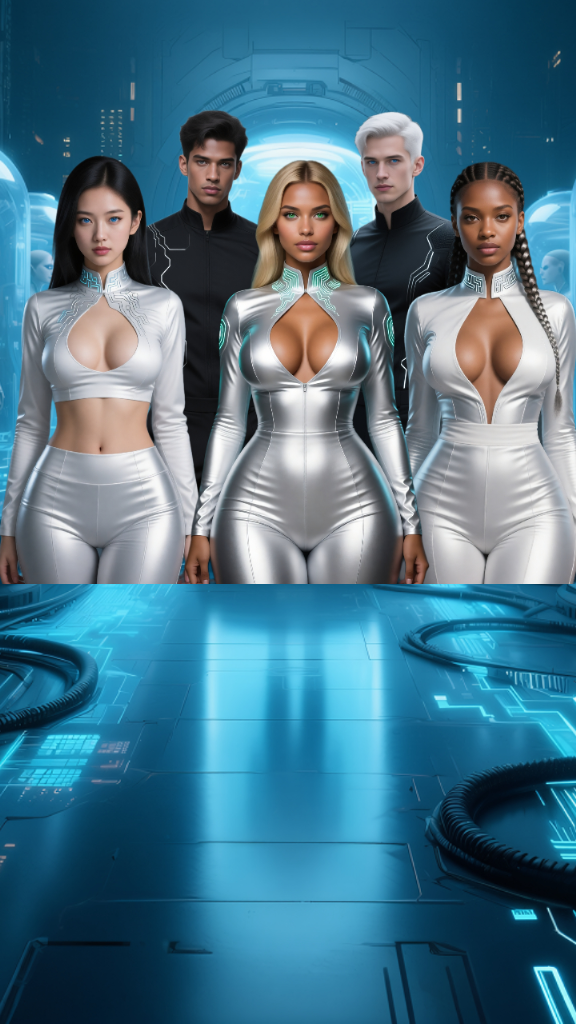

In [9]:
# @markdown # Upload Image 1

file_uploaded = upload_file()
display_upload = True # @param {type:"boolean"}
if display_upload:
    if file_uploaded.lower().endswith(('.png', '.jpg', '.jpeg')):
        display(IPImage(filename=file_uploaded))
    else:
        print("Image format cannnot be displayed.")
recent_upload = True


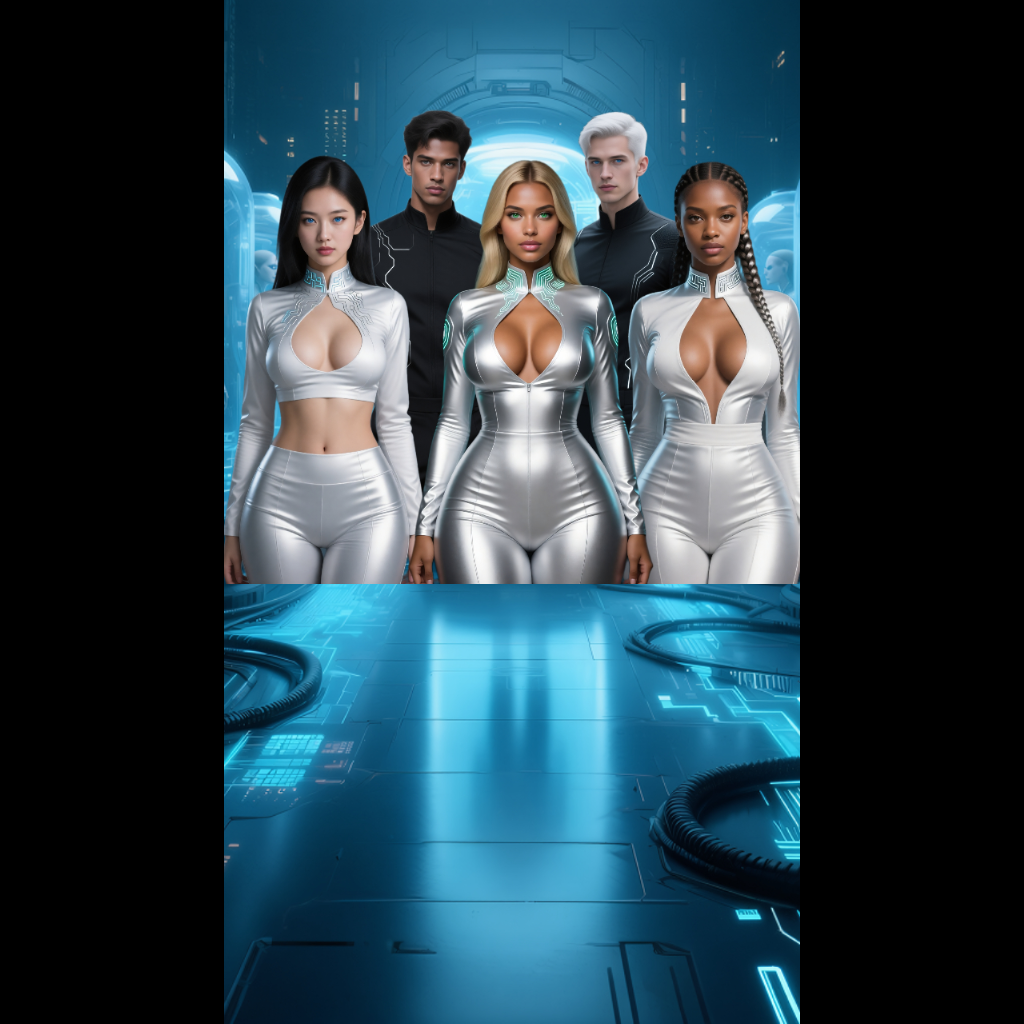

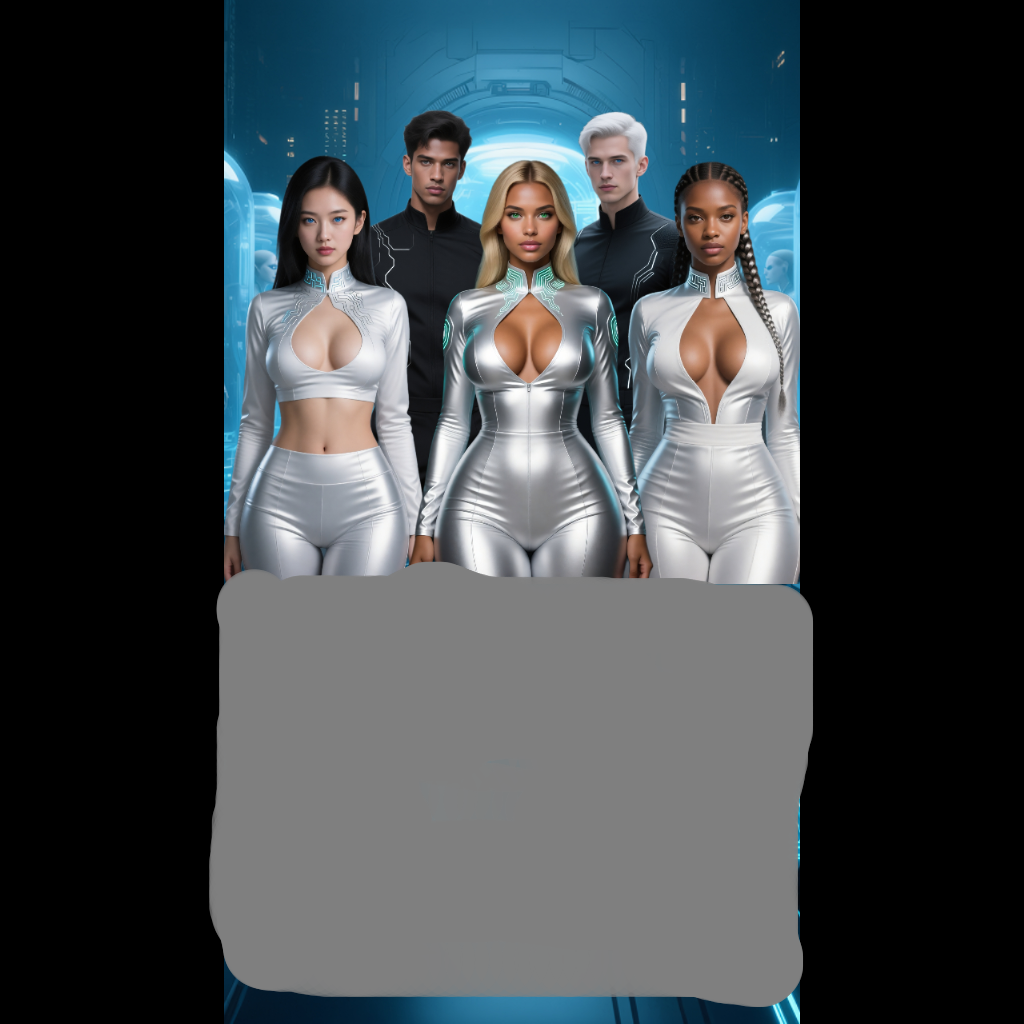

In [11]:
# @markdown # 💥3. Launch Mask Editor for Image 1 & Save after Applying Mask for Inpainting (Experimental)
from google.colab import output
import base64, io


file_uploaded  = globals().get("file_uploaded", None)

if file_uploaded is None:
    print("You need to upload Image 1 before launching the mask editor. ")


edit_recent_output_image=False # @param {type:"boolean"}
display_image_with_mask=True # @param {type:"boolean"}
if edit_recent_output_image and outputImagePath is not None:
    file_uploaded = outputImagePath
if recent_upload:
    load_image_file = LoadImage()
    image_file = load_image_file.load_image(file_uploaded)[0]

    image_file, meta_file = resize_and_pad_to_1024(image_file)
    file_uploaded = save_as_image2(image_file, "image_1024_file")
    recent_upload = False



mask_path = " "

with open(file_uploaded, "rb") as f:
    b64_img = base64.b64encode(f.read()).decode("utf-8")

html = f"""
<div id="editor" style="font-family:system-ui, -apple-system, Segoe UI, Roboto, sans-serif; text-align:center;">
  <h3>🖌️ Mask Editor</h3>

  <div style="margin:8px 0; display:flex; gap:12px; justify-content:center; align-items:center; flex-wrap:wrap;">
    <label>Brush color:
      <input id="colorPicker" type="color" value="#808080" />
    </label>
    <label>Brush size:
      <input id="sizeRange" type="range" min="3" max="100" value="20" />
      <span id="sizeVal">20</span> px
    </label>
    <label>Opacity:
      <input id="opacityRange" type="range" min="10" max="100" value="50" />
      <span id="opacityVal">0.50</span>
    </label>
    <button id="modeBtn" title="Toggle draw/erase">✏️ Draw</button>
    <button id="clearBtn" title="Clear strokes">🧹 Clear</button>
    <button id="saveBtn" style="font-weight:600;">💾 Save Mask</button>
  </div>

  <!-- Three layers: base image, drawing strokes, brush preview -->
  <div style="display:inline-block; position:relative; border:1px solid #000;">
    <canvas id="imgCanvas" style="display:block;"></canvas>
    <canvas id="drawCanvas" style="position:absolute; left:0; top:0;"></canvas>
    <canvas id="brushCanvas" style="position:absolute; left:0; top:0; pointer-events:none;"></canvas>
  </div>
</div>

<script>
(() => {{
  const base64Image = "data:image/png;base64,{b64_img}";
  const imgCanvas = document.getElementById('imgCanvas');
  const drawCanvas = document.getElementById('drawCanvas');
  const brushCanvas = document.getElementById('brushCanvas');
  const imgCtx = imgCanvas.getContext('2d');
  const drawCtx = drawCanvas.getContext('2d');
  const brushCtx = brushCanvas.getContext('2d');

  // Controls
  const colorPicker = document.getElementById('colorPicker');
  const sizeRange = document.getElementById('sizeRange');
  const sizeVal = document.getElementById('sizeVal');
  const opacityRange = document.getElementById('opacityRange');
  const opacityVal = document.getElementById('opacityVal');
  const modeBtn = document.getElementById('modeBtn');
  const clearBtn = document.getElementById('clearBtn');
  const saveBtn = document.getElementById('saveBtn');

  let drawing = false;
  let mode = 'draw'; // 'draw' | 'erase'
  let brushSize = parseInt(sizeRange.value, 10);
  let brushColor = colorPicker.value;
  let brushOpacity = parseInt(opacityRange.value, 10) / 100;

  sizeVal.textContent = brushSize;
  opacityVal.textContent = brushOpacity.toFixed(2);

  // Load base image
  const img = new Image();
  img.src = base64Image;
  img.onload = () => {{
    [imgCanvas, drawCanvas, brushCanvas].forEach(c => {{
      c.width = img.width;
      c.height = img.height;
    }});
    imgCtx.drawImage(img, 0, 0);
    drawCtx.lineCap = 'round';
    drawCtx.lineJoin = 'round';
  }};

  function rgbaFromHex(hex, a) {{
    const h = hex.replace('#', '');
    const r = parseInt(h.substring(0,2), 16);
    const g = parseInt(h.substring(2,4), 16);
    const b = parseInt(h.substring(4,6), 16);
    return `rgba(${{r}}, ${{g}}, ${{b}}, ${{a}})`;
  }}

  function getPos(e) {{
    const rect = drawCanvas.getBoundingClientRect();
    return {{ x: e.clientX - rect.left, y: e.clientY - rect.top }};
  }}

  function pointerDown(e) {{
    e.preventDefault();
    drawing = true;
    const p = getPos(e);
    drawCtx.beginPath();
    drawCtx.moveTo(p.x, p.y);
    drawStroke(e);
  }}

  function pointerMove(e) {{
    const p = getPos(e);

    // Update brush preview
    brushCtx.clearRect(0, 0, brushCanvas.width, brushCanvas.height);
    brushCtx.strokeStyle = brushColor;
    brushCtx.globalAlpha = 1.0;
    brushCtx.lineWidth = 2;
    brushCtx.beginPath();
    brushCtx.arc(p.x, p.y, brushSize/2, 0, Math.PI*2);
    brushCtx.stroke();

    if (drawing) drawStroke(e);
  }}

  function pointerUp() {{
    drawing = false;
  }}

  function drawStroke(e) {{
    const p = getPos(e);
    if (mode === 'erase') {{
      drawCtx.globalCompositeOperation = 'destination-out';
      drawCtx.strokeStyle = 'rgba(0,0,0,1)';
    }} else {{
      drawCtx.globalCompositeOperation = 'source-over';
      drawCtx.strokeStyle = rgbaFromHex(brushColor, brushOpacity);
    }}
    drawCtx.lineWidth = brushSize;
    drawCtx.lineTo(p.x, p.y);
    drawCtx.stroke();
    drawCtx.beginPath();
    drawCtx.moveTo(p.x, p.y);
  }}

  // Events
  drawCanvas.addEventListener('pointerdown', pointerDown);
  drawCanvas.addEventListener('pointermove', pointerMove);
  window.addEventListener('pointerup', pointerUp);
  drawCanvas.addEventListener('pointerleave', pointerUp);

  // UI Controls
  colorPicker.addEventListener('input', e => brushColor = e.target.value);
  sizeRange.addEventListener('input', e => {{
    brushSize = parseInt(e.target.value, 10);
    sizeVal.textContent = brushSize;
  }});
  opacityRange.addEventListener('input', e => {{
    brushOpacity = parseInt(e.target.value, 10) / 100;
    opacityVal.textContent = brushOpacity.toFixed(2);
  }});
  modeBtn.addEventListener('click', () => {{
    mode = (mode === 'draw') ? 'erase' : 'draw';
    modeBtn.textContent = (mode === 'draw') ? '✏️ Draw' : '🧽 Erase';
  }});
  clearBtn.addEventListener('click', () => drawCtx.clearRect(0, 0, drawCanvas.width, drawCanvas.height));

  // Save mask + overlay
  saveBtn.addEventListener('click', () => {{
    const overlayCanvas = document.createElement('canvas');
    overlayCanvas.width = imgCanvas.width;
    overlayCanvas.height = imgCanvas.height;
    const octx = overlayCanvas.getContext('2d');
    octx.drawImage(imgCanvas, 0, 0);
    octx.drawImage(drawCanvas, 0, 0);
    const overlayDataURL = overlayCanvas.toDataURL('image/png');

    const maskCanvas = document.createElement('canvas');
    maskCanvas.width = drawCanvas.width;
    maskCanvas.height = drawCanvas.height;
    const mctx = maskCanvas.getContext('2d');
    const strokeData = drawCtx.getImageData(0, 0, drawCanvas.width, drawCanvas.height);
    const d = strokeData.data;
    const thresh = 10;
    for (let i = 0; i < d.length; i += 4) {{
      const a = d[i+3];
      if (a > thresh) {{
        d[i]=255; d[i+1]=255; d[i+2]=255; d[i+3]=255;
      }} else {{
        d[i]=0; d[i+1]=0; d[i+2]=0; d[i+3]=255;
      }}
    }}
    mctx.putImageData(strokeData,0,0);
    const maskDataURL = maskCanvas.toDataURL('image/png');

    google.colab.kernel.invokeFunction('notebook.save_mask_js',
      [overlayDataURL, maskDataURL], {{}});

    document.getElementById('editor').innerHTML = "<p><b>✅ Mask saved!</b></p>";
  }});
}})();
</script>
"""

def _decode_data_url_to_pil(data_url: str) -> Image.Image:
  header, b64 = data_url.split(',', 1)
  return Image.open(io.BytesIO(base64.b64decode(b64)))

def save_mask_js(overlay_data_url: str, mask_data_url: str):
  overlay = _decode_data_url_to_pil(overlay_data_url).convert("RGBA")
  mask = _decode_data_url_to_pil(mask_data_url).convert("L")
  global mask_path
  global display_image_with_mask
  overlay.save("/content/overlay.png")
  # global mask_path
  mask_path = "/content/mask.png"
  mask.save(mask_path)
  # print("✅ Saved: /content/overlay.png")
  if display_image_with_mask:
      display(overlay)
  # print("✅ Saved: /content/mask.png")
  # display(mask)

output.register_callback("notebook.save_mask_js", save_mask_js)
display(HTML(html))



In [ ]:
# @markdown # Upload Image 2 (optional)

file_uploaded2 = upload_file()
display_upload = False # @param {type:"boolean"}
if display_upload:
    if file_uploaded2.lower().endswith(('.png', '.jpg', '.jpeg')):
        display(IPImage(filename=file_uploaded2))
    else:
        print("Image format cannnot be displayed.")


In [ ]:
# @markdown # Upload Image 3 (optional)

file_uploaded3 = upload_file()
display_upload = False # @param {type:"boolean"}
if display_upload:
    if file_uploaded3.lower().endswith(('.png', '.jpg', '.jpeg')):
        display(IPImage(filename=file_uploaded3))
    else:
        print("Image format cannnot be displayed.")

Editing image...


  0%|          | 0/4 [00:00<?, ?it/s]

Decoding latents...


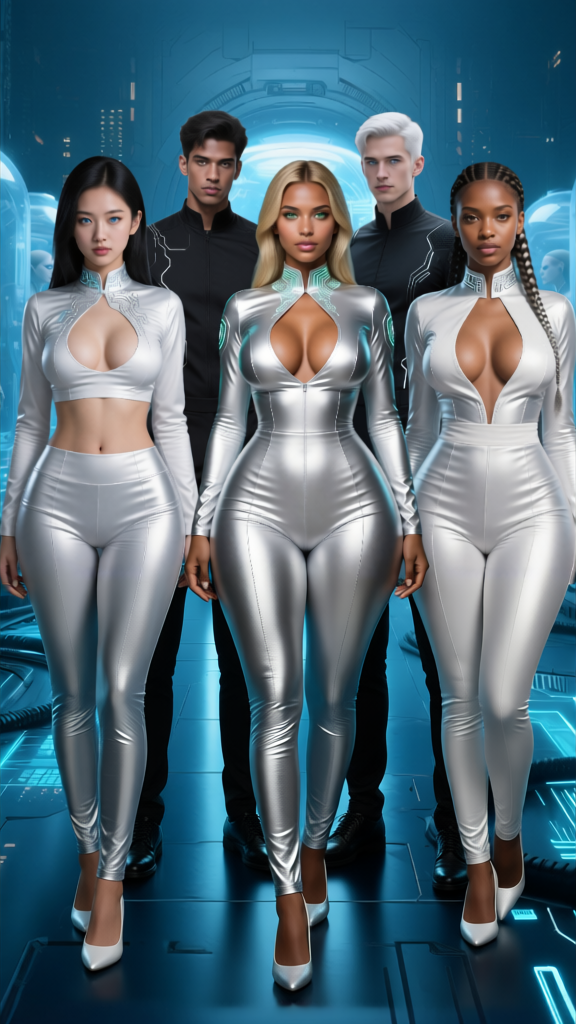

Seed: 1357468872
✅ Generation completed in 5 min 56.81 sec


In [8]:
# @markdown # 💥2. Edit Image


import time
start_time = time.time()

positive_prompt="Complete the image by showing the legs of each character" # @param {"type":"string"}
negative_prompt="jpeg compression" # @param {"type":"string"}
shift=3 # @param {"type":"slider","min":0.0,"max":100.0,"step":0.1}
# @markdown ---
# @markdown ### Image Settings
# generate_image=False # @param {type:"boolean"}
# generate_image=False
use_inpainting=True # @param {type:"boolean"}
convert_image_3_to_pose=False # @param {type:"boolean"}
do_not_use_uploaded_image1=False # @param {type:"boolean"}
do_not_use_uploaded_image2=False # @param {type:"boolean"}
do_not_use_uploaded_image3=False # @param {type:"boolean"}
change_resolution=False # @param {type:"boolean"}
new_width = 512 # @param {"type":"number"}
new_height = 768 # @param {"type":"number"}
pad_output_to_1024_by_1024 = False # @param {type:"boolean"}
change_output_resolution=False
width_out = 768
height_out = 1360
resize_output=False # @param {type:"boolean"}
r_width=720 # @param {"type":"number"}
r_height=1280 # @param {"type":"number"}
edit_output_image=False # @param {type:"boolean"}
overwrite_previous_output=False # @param {type:"boolean"}
# @markdown ---
# @markdown ### Sampler Settings
seed=0 # @param {"type":"integer"}
steps = 20 # @param {"type":"slider","min":0,"max":100,"step":1}
cfg = 2.5 # @param {"type":"slider","min":0,"max":20,"step":0.5}
sampler_name="euler" # @param ["uni_pc", "uni_pc_bh2", "ddim","euler", "euler_cfg_pp", "euler_ancestral", "euler_ancestral_cfg_pp", "heun", "heunpp2","dpm_2", "dpm_2_ancestral","lms", "dpm_fast", "dpm_adaptive", "dpmpp_2s_ancestral", "dpmpp_2s_ancestral_cfg_pp", "dpmpp_sde", "dpmpp_sde_gpu","dpmpp_2m", "dpmpp_2m_cfg_pp", "dpmpp_2m_sde", "dpmpp_2m_sde_gpu", "dpmpp_3m_sde", "dpmpp_3m_sde_gpu", "ddpm", "lcm","ipndm", "ipndm_v", "deis", "res_multistep", "res_multistep_cfg_pp", "res_multistep_ancestral", "res_multistep_ancestral_cfg_pp","gradient_estimation", "er_sde", "seeds_2", "seeds_3"]
scheduler="simple" # @param ["simple","normal","karras","exponential","sgm_uniform","ddim_uniform","beta","linear_quadratic","kl_optimal"]
denoise=1 # @param {"type":"slider","min":0.0,"max":1.0,"step":0.01}
# @markdown ---
# @markdown ### LoRA Settings
use_speedup_lora=True # @param {type:"boolean"}
use_lora=False # @param {type:"boolean"}
LoRA_Strength=1 # @param {"type":"slider","min":-10,"max":10,"step":0.01}
use_lora2=False # @param {type:"boolean"}
LoRA2_Strength=1 # @param {"type":"slider","min":-10,"max":10,"step":0.01}
use_lora3=False # @param {type:"boolean"}
LoRA3_Strength=1 # @param {"type":"slider","min":-10,"max":10,"step":0.01}
use_lora4=False # @param {type:"boolean"}
LoRA4_Strength=1 # @param {"type":"slider","min":-10,"max":10,"step":0.01}

file_uploaded11  = globals().get("file_uploaded", None)
file_uploaded22 = globals().get("file_uploaded2", None)
file_uploaded33 = globals().get("file_uploaded3", None)

# file_uploaded11=None

mask_path_checked = globals().get("mask_path", None)

meta_file_from_mask = globals().get("meta_file", None)

# print(meta_file_from_mask)

if edit_output_image and outputImagePath is not None:
    file_uploaded11 = outputImagePath
    file_uploaded22 = None
    file_uploaded33 = None

import random
seed = seed if seed != 0 else random.randint(0, 2**32 - 1)
print(f"Using seed: {seed}")

if do_not_use_uploaded_image1 and file_uploaded11 is not None:
    file_uploaded11 = None

if do_not_use_uploaded_image2 and file_uploaded22 is not None:
    file_uploaded22 = None

if do_not_use_uploaded_image3 and file_uploaded33 is not None:
    file_uploaded33 = None

edit_input(
    image_path = file_uploaded11,
    use_inpainting=use_inpainting,
    mask_path = mask_path_checked,
    meta_file_from_mask = meta_file_from_mask,
    image_path2 = file_uploaded22,
    image_path3 = file_uploaded33,
    positive_prompt = positive_prompt,
    negative_prompt = negative_prompt,
    guidance = shift,
    convert_image_3_to_pose = convert_image_3_to_pose,
    change_resolution=change_resolution,
    width=new_width,
    height=new_height,
    change_output_resolution=change_output_resolution,
    width_out=width_out,
    height_out=height_out,
    pad_output_to_1024_by_1024=pad_output_to_1024_by_1024,
    resize_final_output=resize_output,
    r_width=r_width,
    r_height=r_height,
    seed = seed,
    steps = steps,
    cfg = cfg,
    sampler_name = sampler_name,
    scheduler = scheduler,
    denoise = denoise,
    use_turbo_lora = use_speedup_lora,
    use_lora = use_lora,
    LoRA_Strength = LoRA_Strength,
    use_lora2 = use_lora2,
    LoRA2_Strength = LoRA2_Strength,
    use_lora3 = use_lora3,
    LoRA3_Strength = LoRA3_Strength,
    use_lora4 = use_lora4,
    LoRA4_Strength = LoRA4_Strength,
    overwrite = overwrite_previous_output
)

end_time = time.time()
duration = end_time - start_time
mins, secs = divmod(duration, 60)
print(f"Seed: {seed}")
print(f"✅ Generation completed in {int(mins)} min {secs:.2f} sec")

clear_memory()